In [1]:
!pip install -q torch==2.2.0 tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [12]:
!pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.2.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import math, random, time
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CopyTask(Dataset):
    """
    Generates (seq, seq) where seq is a list of ints in [1, vocab_size).
    The first token is always 0 (SOS), last is vocab_size (EOS).
    """
    def __init__(self, num_samples=10_000, seq_len=12, vocab_size=20):
        self.vocab_size, self.seq_len = vocab_size, seq_len
        self.data = [
            torch.randint(1, vocab_size, (seq_len,)) for _ in range(num_samples)
        ]

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        x = torch.cat([torch.zeros(1, dtype=torch.long), self.data[idx]])      # SOS
        y = torch.cat([self.data[idx], torch.full((1,), self.vocab_size)])     # EOS
        return x, y

In [3]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x, mask=None):
        Q, K, V = self.W_q(x), self.W_k(x), self.W_v(x)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_model)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = self.softmax(scores)
        return attn @ V, attn          # we return attn for visualisation

In [4]:
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size+1, d_model)  # +1 for EOS
        self.attn  = SingleHeadAttention(d_model)
        self.fc    = nn.Linear(d_model, vocab_size+1)
    def forward(self, x):
        x = self.embed(x)
        # Causal mask: do not peek ahead
        seq_len = x.size(1)
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        x, w = self.attn(x, mask)
        return self.fc(x), w

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ds   = CopyTask()
dl   = DataLoader(ds, batch_size=64, shuffle=True)
model = TinyTransformer(ds.vocab_size).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=3e-4)
losses = []

for epoch in range(5):
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits, _ = model(xb)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), yb.view(-1))
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
    print(f"epoch {epoch+1}: {losses[-1]:.3f}")

epoch 1: 2.963
epoch 2: 2.907
epoch 3: 2.876
epoch 4: 2.874
epoch 5: 2.852


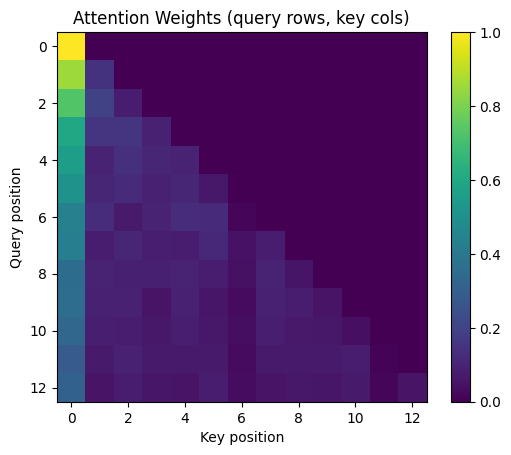

In [6]:
# Pick one random sample and plot its attention weights
model.eval()
test_x, _ = ds[random.randint(0, len(ds)-1)]
with torch.no_grad():
    _, attn = model(test_x.unsqueeze(0).to(device))
attn = attn.squeeze(0).cpu()  # [seq, seq]

# Convert the PyTorch tensor to a NumPy array before plotting.
attn = attn.numpy()

plt.imshow(attn, cmap='viridis')
plt.title("Attention Weights (query rows, key cols)")
plt.xlabel("Key position"); plt.ylabel("Query position")
plt.colorbar(); plt.show()